# House Prices: Advanced Regression Techniques

### **Goal**
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### **Metric**
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### **Submission File Format**
The file should contain a header and have the following format:

    Id,SalePrice
    1461,169000.1
    1462,187724.1233
    1463,175221
etc.

<https://www.kaggle.com/c/house-prices-advanced-regression-techniques/>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import scipy.stats as stats

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
def multi_levene(df, col_names, target):
    group_df = df.pivot(columns = col_names, values = target)
    pvals = []
    for i in range(len(group_df.columns)-1):
        pval = stats.levene(group_df.iloc[:,i].dropna(), group_df.iloc[:,i+1].dropna()).pvalue
        pvals.append(pval)

    return max(pvals)

In [6]:
text_columns = train.columns[train.dtypes == object]
train['total_SF'] = train[['TotalBsmtSF','1stFlrSF','2ndFlrSF']].sum(axis=1)
train['price_per_SF'] = train['SalePrice']/train['total_SF']

In [7]:
levene_df = pd.DataFrame()
for col in text_columns:
    levene_df = levene_df.append([[col,multi_levene(train, col, 'price_per_SF')]])
    
levene_df.columns = ['feature','score']

C:\Users\jakes\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:2369: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
C:\Users\jakes\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\jakes\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\jakes\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\jakes\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:2369: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom


In [8]:
irrelevant_cols = levene_df.loc[levene_df['score']<0.05,'feature']

In [9]:
train_dummies = pd.get_dummies(train[text_columns])

In [10]:
train_corr = train.drop('price_per_SF',axis=1).corr()
target_variables = train_corr.nlargest(11, 'SalePrice').index.tolist()

target_vars = [word for word in target_variables if word != 'SalePrice']

In [11]:
from sklearn.model_selection import train_test_split

X = train[target_vars].join(train_dummies)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [16]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [18]:
y_pred = reg.predict(X_test)

regression_results(y_test, y_pred)

explained_variance:  0.8662
mean_squared_log_error:  0.0303
r2:  0.8661
MAE:  20078.3835
MSE:  982845346.2991
RMSE:  31350.3644


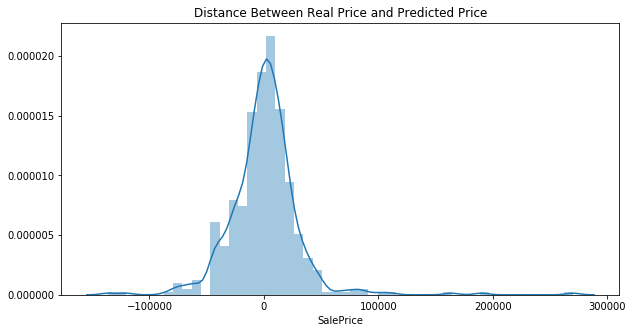

In [19]:
plt.figure(figsize=(10,5))
sns.distplot(y_test-y_pred)
plt.title('Distance Between Real Price and Predicted Price')
plt.show()